In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, GRU
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
df = pd.read_csv('data.csv', index_col=False)
print(df.columns)
df.head()

Index(['clouds', 'datetime', 'dewpt', 'dhi', 'dni', 'ghi', 'pres', 'rh', 'slp',
       'temp', 'wind_gust_spd', 'wind_spd', 'precip'],
      dtype='object')


,clouds,datetime,dewpt,dhi,dni,ghi,pres,rh,slp,temp,wind_gust_spd,wind_spd,precip
0,18,01/01/2021,4.1,40,331,210,1025,56,1025,13.2,8.0,1.9,0.0
1,17,02/01/2021,7.0,40,331,211,1022,66,1022,14.0,6.4,1.4,0.0
2,90,03/01/2021,9.7,40,332,211,1021,74,1021,14.6,7.2,1.6,0.0
3,98,04/01/2021,9.4,41,332,212,1020,59,1021,17.7,6.0,1.0,0.0
4,100,05/01/2021,13.6,41,332,212,1020,76,1020,18.1,5.6,1.0,0.0


In [3]:
columns = list(df.columns)
columns.append(columns.pop(columns.index('precip')))
df = df[columns]
df.head()


,clouds,datetime,dewpt,dhi,dni,ghi,pres,rh,slp,temp,wind_gust_spd,wind_spd,precip
0,18,01/01/2021,4.1,40,331,210,1025,56,1025,13.2,8.0,1.9,0.0
1,17,02/01/2021,7.0,40,331,211,1022,66,1022,14.0,6.4,1.4,0.0
2,90,03/01/2021,9.7,40,332,211,1021,74,1021,14.6,7.2,1.6,0.0
3,98,04/01/2021,9.4,41,332,212,1020,59,1021,17.7,6.0,1.0,0.0
4,100,05/01/2021,13.6,41,332,212,1020,76,1020,18.1,5.6,1.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clouds         1669 non-null   int64  
 1   datetime       1669 non-null   object 
 2   dewpt          1669 non-null   float64
 3   dhi            1669 non-null   int64  
 4   dni            1669 non-null   int64  
 5   ghi            1669 non-null   int64  
 6   pres           1669 non-null   int64  
 7   rh             1669 non-null   int64  
 8   slp            1669 non-null   int64  
 9   temp           1669 non-null   float64
 10  wind_gust_spd  1669 non-null   float64
 11  wind_spd       1669 non-null   float64
 12  precip         1669 non-null   float64
dtypes: float64(5), int64(7), object(1)
memory usage: 169.6+ KB


In [5]:
df['precip'].describe()

count    1669.000000
mean        4.052846
std        10.038594
min         0.000000
25%         0.000000
50%         0.000000
75%         3.500000
max       120.500000
Name: precip, dtype: float64

### Biểu đồ chuỗi thời gian

In [6]:
# Vẽ biểu đồ chuỗi thời gian với cột 'precip' sử dụng Plotly
fig = px.line(df, x='datetime', y='precip', title='Biểu đồ lượng mưa theo thời gian')
fig.update_xaxes(title_text='Thời gian')
fig.update_yaxes(title_text='Lượng mưa')
fig.show()

### Biểu đồ Heatmap

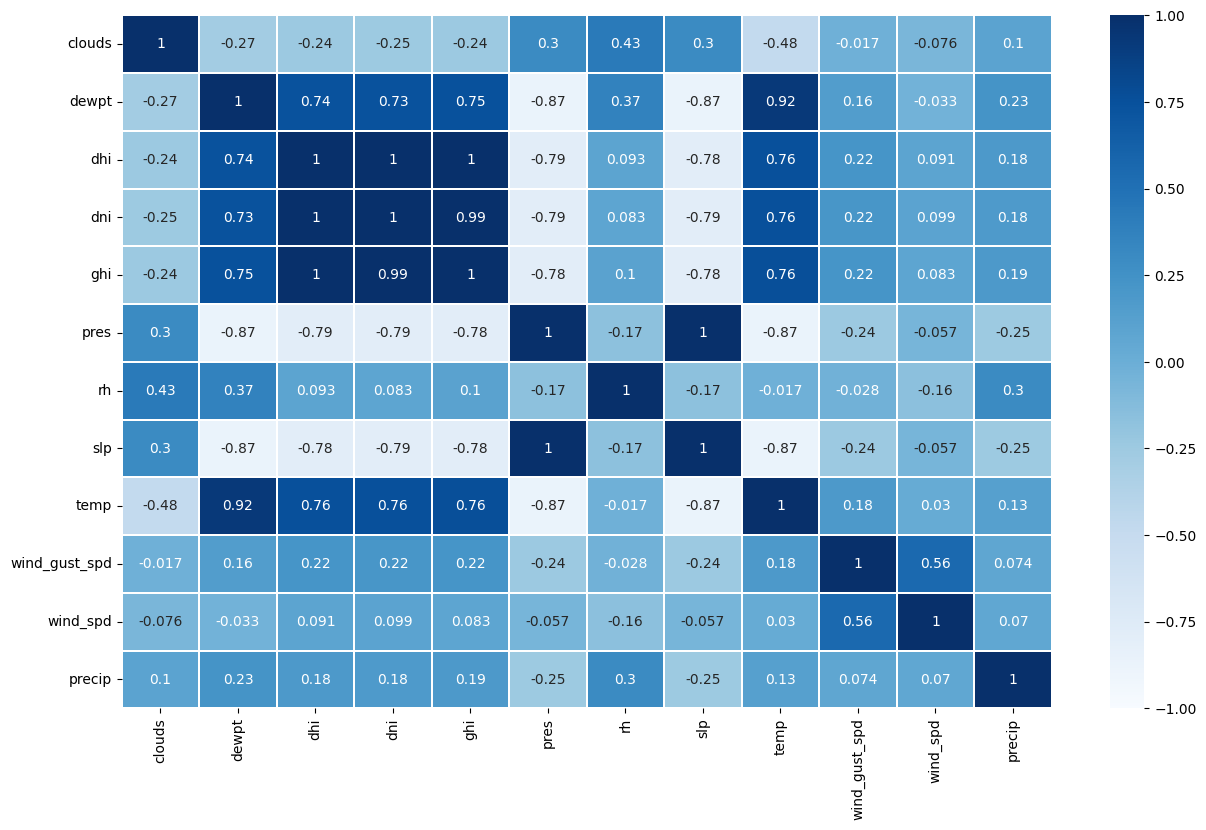

In [7]:
# Correlation HeatMap
import seaborn as sns
import pandas as pd

plt.figure(figsize=(15,9))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, linewidth=0.1, cmap="Blues",  vmin=-1, vmax=1)

plt.show()

### Thực hiện phân tích theo mùa vụ

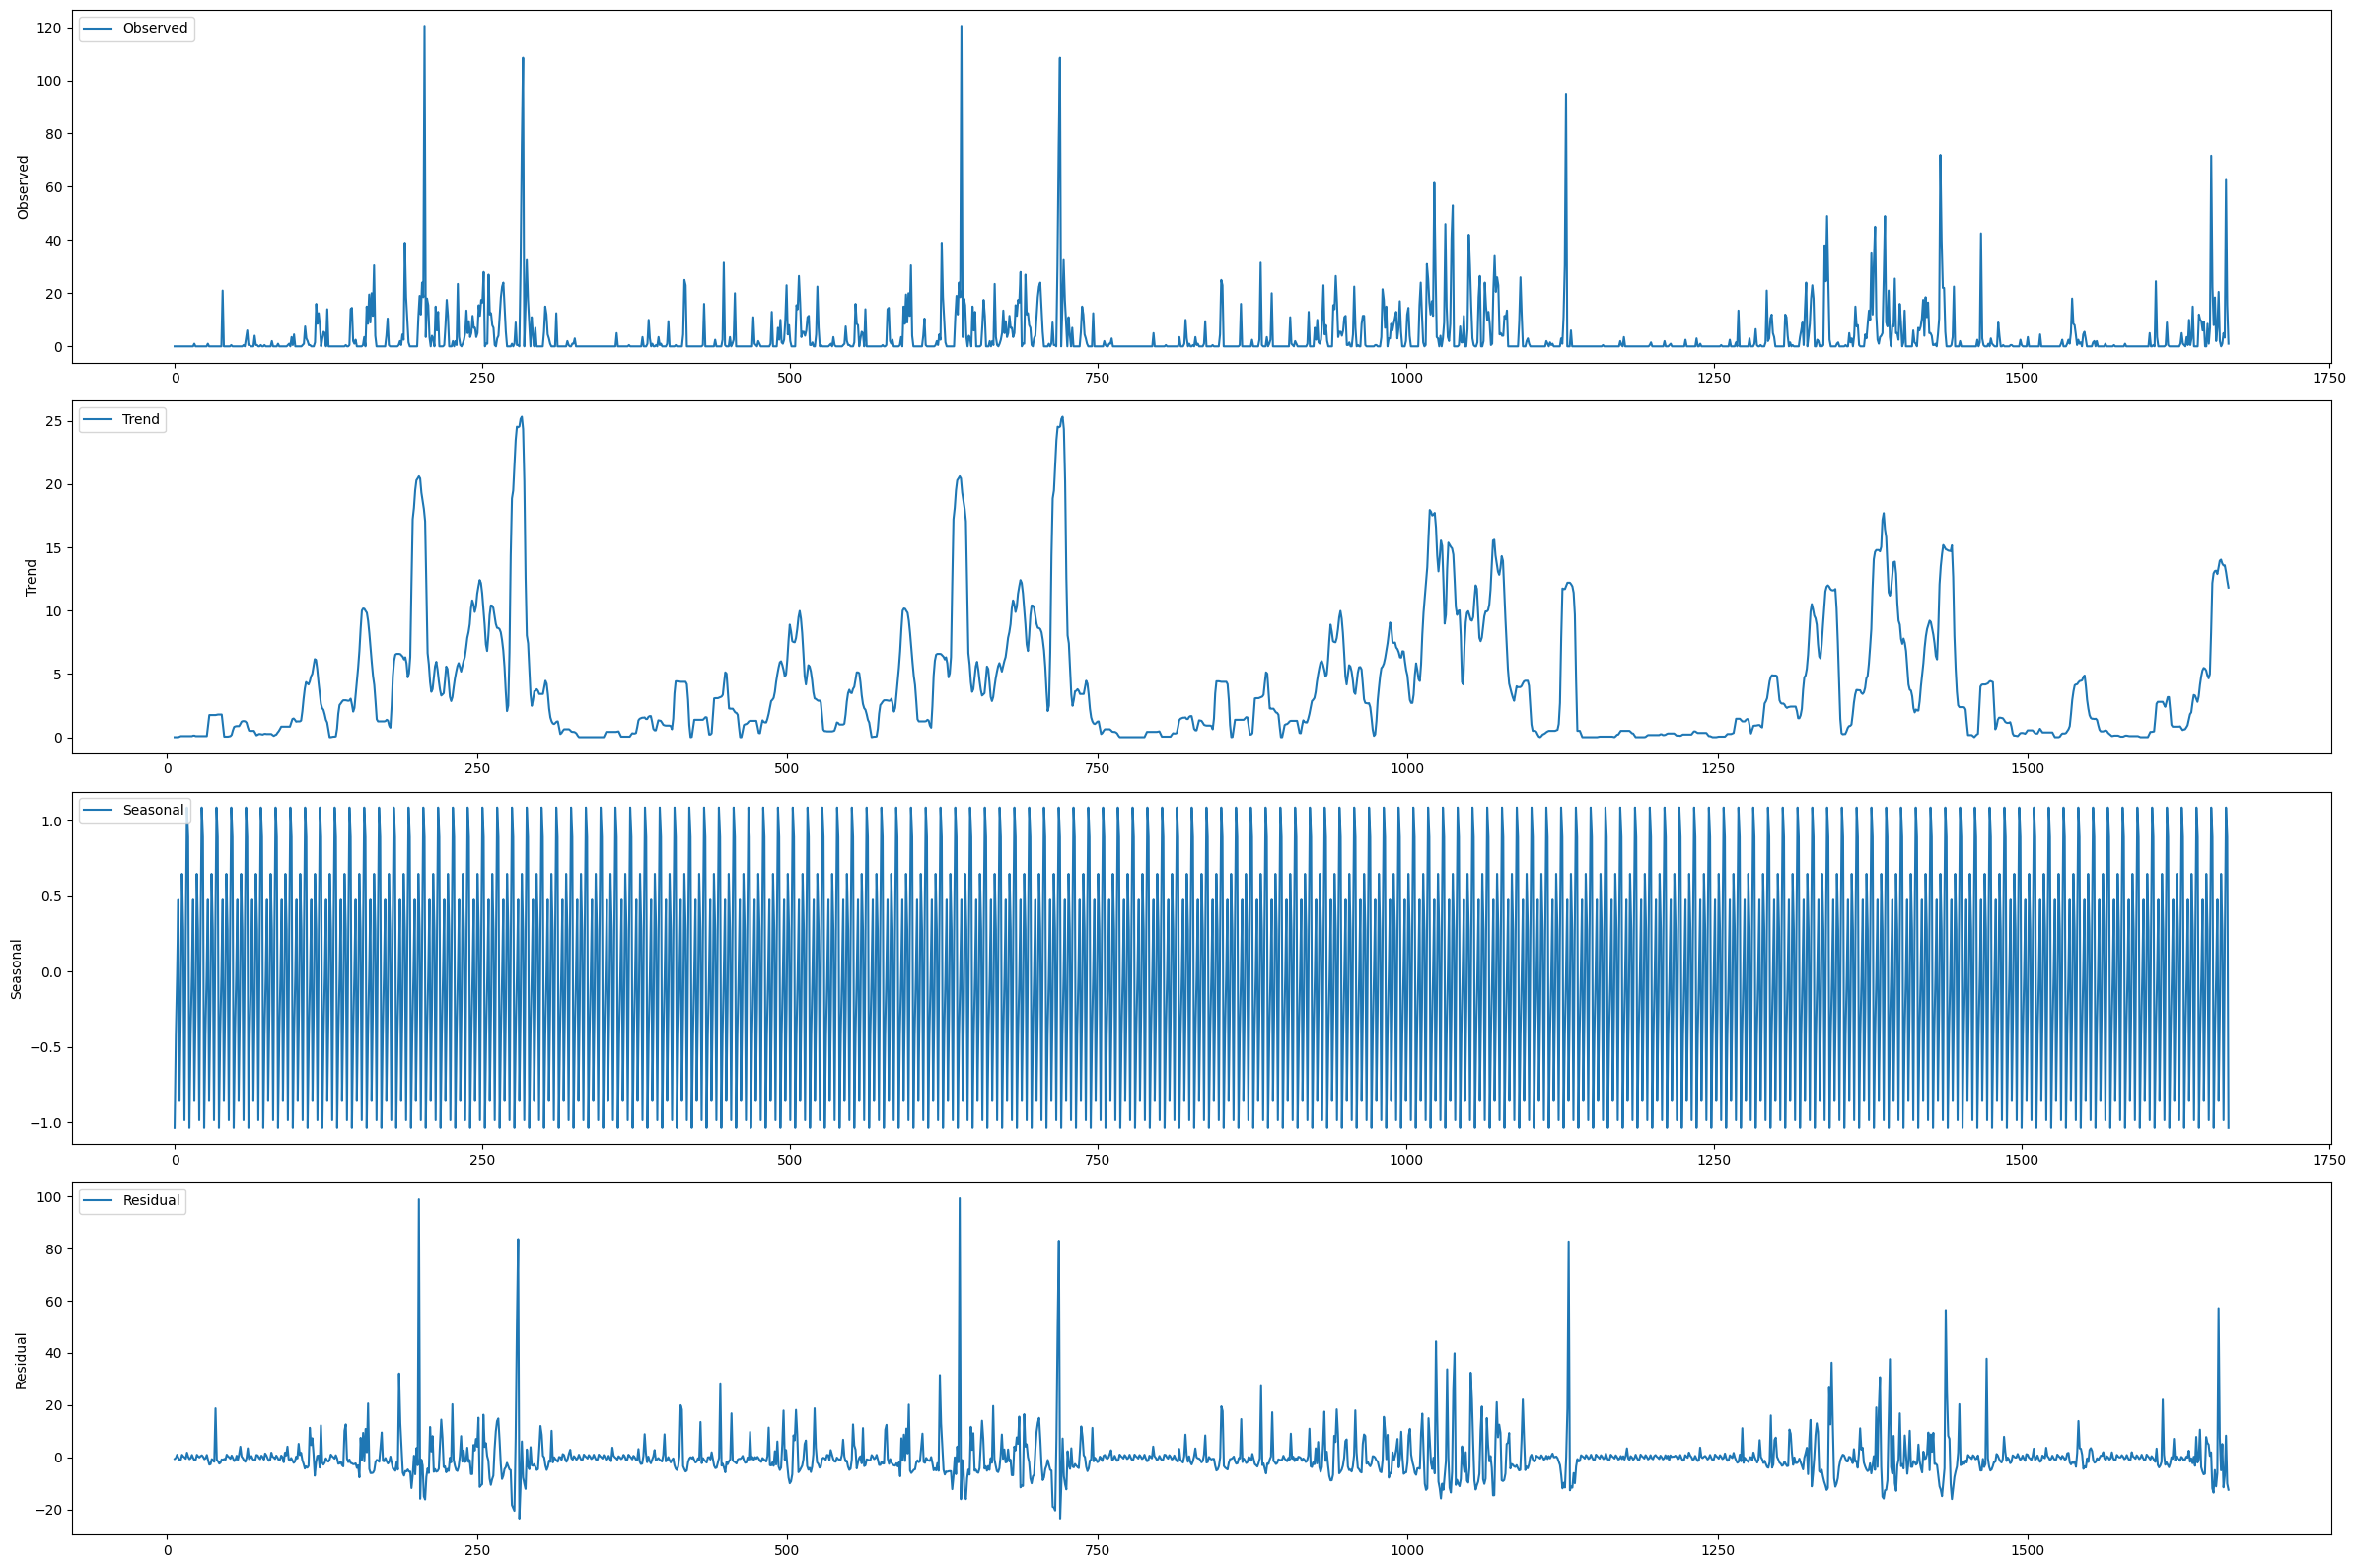

In [8]:
# Thực hiện phân tích theo mùa vụ
result = seasonal_decompose(df['precip'], model='additive', period=12)

# Vẽ các thành phần
plt.figure(figsize=(24, 16))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.ylabel('Observed')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

In [9]:
df.drop(columns=['datetime'], inplace=True)

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)


# Áp dụng scaler lên toàn bộ dữ liệu và ghi đè lên dữ liệu gốc
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()



,clouds,dewpt,dhi,dni,ghi,pres,rh,slp,temp,wind_gust_spd,wind_spd,precip
0,0.18,0.170732,0.000000,0.033333,0.014599,0.848485,0.267857,0.848485,0.187023,0.321637,0.304348,0.0
1,0.17,0.271777,0.000000,0.033333,0.021898,0.757576,0.446429,0.757576,0.217557,0.228070,0.195652,0.0
2,0.90,0.365854,0.000000,0.044444,0.021898,0.727273,0.589286,0.727273,0.240458,0.274854,0.239130,0.0
3,0.98,0.355401,0.076923,0.044444,0.029197,0.696970,0.321429,0.727273,0.358779,0.204678,0.108696,0.0
4,1.00,0.501742,0.076923,0.044444,0.029197,0.696970,0.625000,0.696970,0.374046,0.181287,0.108696,0.0


In [11]:
train, test = train_test_split(df, test_size=0.2)
y_train = train['precip']
x_train = train.drop(columns='precip')
y_test = test['precip']
x_test = test.drop(columns='precip')

### Mô hình SVM

In [12]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Định nghĩa tham số cho GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'epsilon': [0.1, 0.01, 0.001]
}

# Tạo GridSearchCV cho SVM
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, refit=True, verbose=2)
grid_search.fit(x_train, y_train)

# Lấy mô hình tốt nhất
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(x_test)

# Đặt các giá trị âm thành 0 nếu cần thiết
y_pred_svm = np.maximum(y_pred_svm, 0)

# Đánh giá mô hình bằng RMSE
rmse_svm = mean_squared_error(y_test, y_pred_svm, squared=False)
print("Root Mean Squared Error (RMSE) of SVM:", rmse_svm)
print("Best parameters found by GridSearchCV:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.0s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.0s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.0s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.0s
[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.0s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.0s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.0s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.0s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.0s
[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10588\1096462251.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



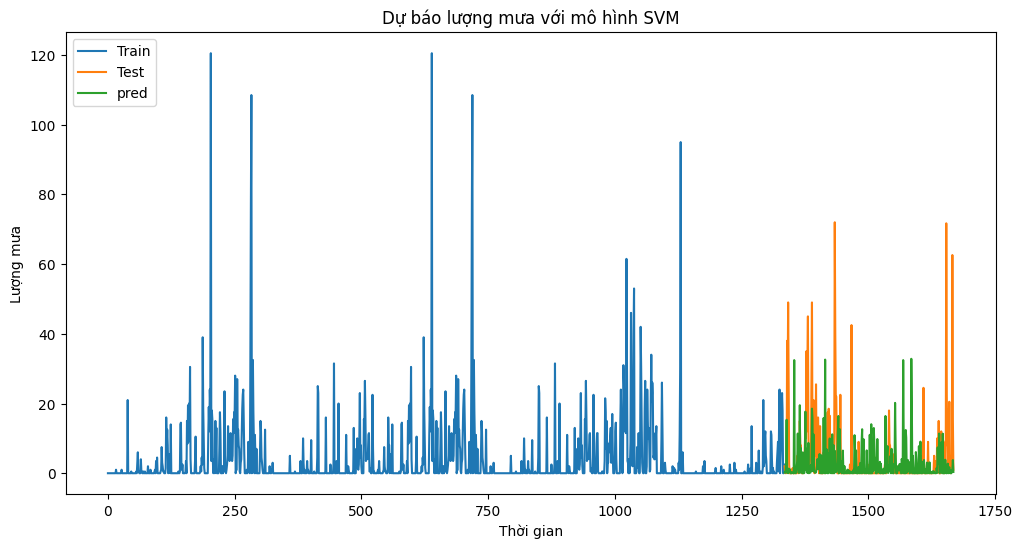

In [13]:
# Vẽ biểu đồ kết quả dự đoán
train_size = len(x_train)
train = df[:train_size]
valid = df[train_size:]
valid['pred_SVM'] = y_pred_svm

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pred_SVM']])
plt.title('Dự báo lượng mưa với mô hình SVM')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()

### Mô hình XGBoost

In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Định nghĩa mô hình XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Định nghĩa các giá trị tham số cần tối ưu
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],  # Tốc độ học
    'max_depth': [10, 12, 14],          # Độ sâu tối đa của cây
    'n_estimators': [50, 100, 200]      # Số lượng cây
}

# Sử dụng GridSearchCV để tìm bộ tham số tối ưu
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Huấn luyện Grid Search trên dữ liệu huấn luyện
grid_search.fit(x_train, y_train)

# In ra các thông số tối ưu
print("Best parameters found: ", grid_search.best_params_)
print("Lowest RMSE found: ", -grid_search.best_score_)  # Đổi dấu vì grid_search sử dụng negative RMSE

# Dự đoán trên tập kiểm tra với tham số tối ưu
best_model = grid_search.best_estimator_
predict_XGB = best_model.predict(x_test)
rmse_XGBoost = mean_squared_error(y_test, predict_XGB, squared=False)
print("Root Mean Squared Error (RMSE) with best parameters:", rmse_XGBoost)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}
Lowest RMSE found:  6.770047193176616
Root Mean Squared Error (RMSE) with best parameters: 6.404389453730086


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10588\1019103977.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



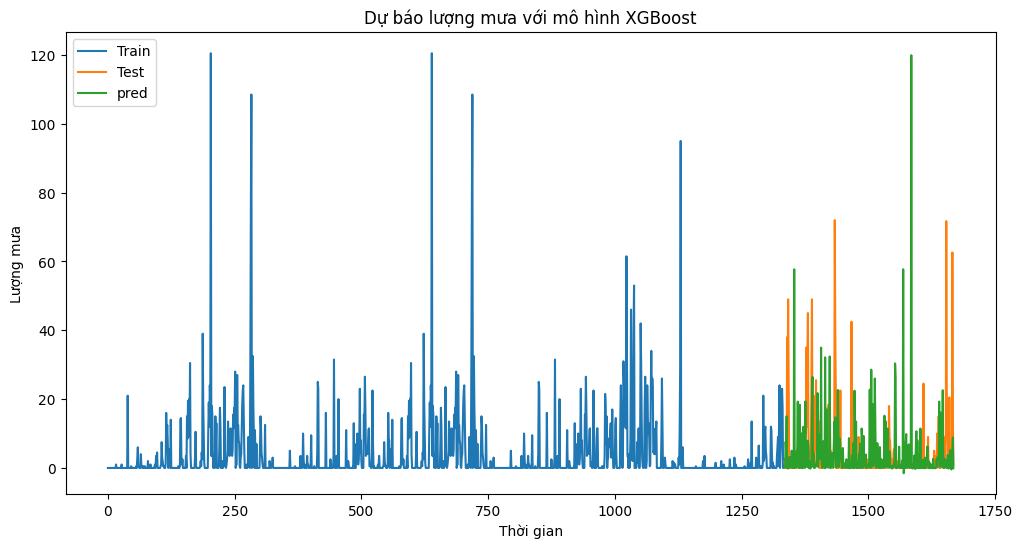

In [15]:
# Vẽ biểu đồ kết quả dự đoán

valid['pred_XGB'] = predict_XGB

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pred_XGB']])
plt.title('Dự báo lượng mưa với mô hình XGBoost')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()

### Mô hình RNN

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(10, 1)),
    SimpleRNN(100, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=50)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 59.5202
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68.2537
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66.1565
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.1974
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87.1748
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87.8637
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90.6249
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 106.0710
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104.6089
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104.7956
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.6821
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74.2506
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91.1619
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 76.2604
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62.8513
E

In [17]:
predict_rnn = model.predict(x_test)

# Đánh giá mô hình bằng RMSE
rmse_rnn = np.sqrt(mean_squared_error(y_test, predict_rnn))
print("Root Mean Squared Error (RMSE) of RNN:", rmse_rnn)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Root Mean Squared Error (RMSE) of RNN: 12.042817572295649


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10588\1803610995.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



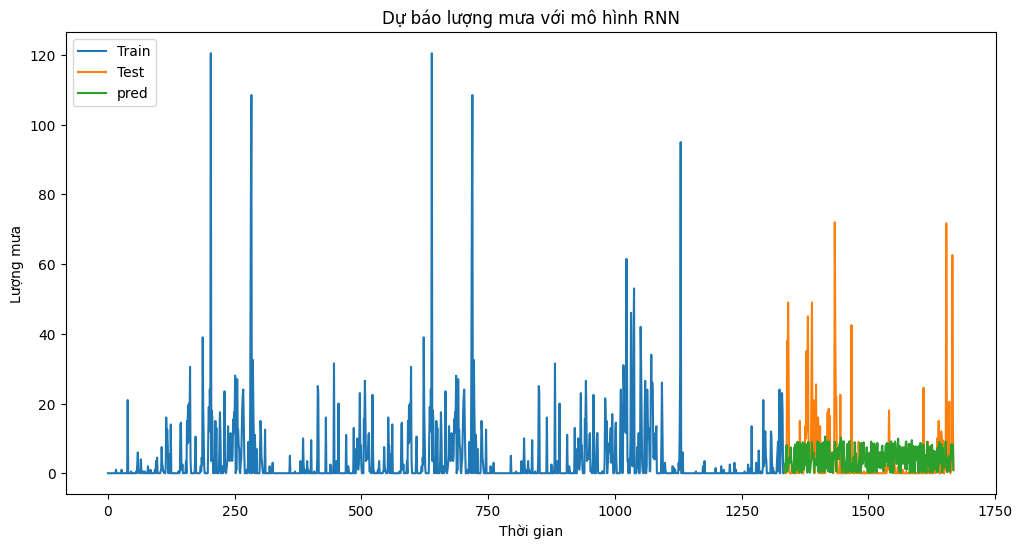

In [18]:
# Vẽ biểu đồ kết quả dự đoán
valid['pre_rnn'] = predict_rnn

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pre_rnn']])
plt.title('Dự báo lượng mưa với mô hình RNN')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()

### Mô hình LSTM

In [19]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(10, 1)),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=50)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 73.5257
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 65.4089
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83.0061
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 74.5372
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 104.2615
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 112.4932
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 107.4366
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 87.8027
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 81.8088
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 81.0294
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 60.9341
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 68.7991
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 90.9368
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 77.5894
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 75.8476
E

In [20]:
# Dự đoán trên tập kiểm tra
predict_LSTM = model.predict(x_test)

# Đánh giá mô hình
import math

rmse_LSTM = math.sqrt(mean_squared_error(y_test, predict_LSTM))
print(f'Root Mean Squared Error: {rmse_LSTM}') 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Root Mean Squared Error: 11.900712627701106


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10588\2223699476.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



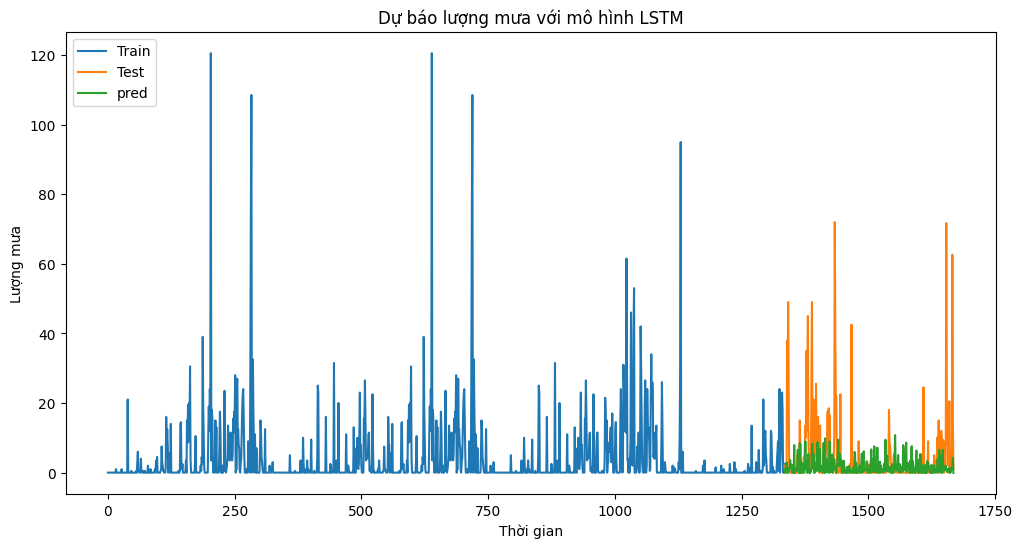

In [21]:
# Vẽ biểu đồ kết quả dự đoán
valid['pre_lstm'] = predict_LSTM

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pre_lstm']])
plt.title('Dự báo lượng mưa với mô hình LSTM')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()

### Mô hình GRU

In [22]:
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(20, 1)),
    GRU(100, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.fit(x_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 83.4467
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 89.8249
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 87.2188
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 72.2531
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 74.6375
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 69.1513
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83.9611
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 87.8370
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 60.3829
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 120.0081
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 90.3583
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 61.2931
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 67.9157
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 70.4493
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 76.1960
Epo

In [23]:
# Dự đoán lượng mưa cho dữ liệu thử nghiệm (y_test)
predict_GRU = model.predict(x_test)
# Tính RMSE
rmse_GRU = np.sqrt(mean_squared_error(y_test, predict_GRU))

print("RMSE:", rmse_GRU)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
RMSE: 10.417125179613706


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10588\1074642523.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



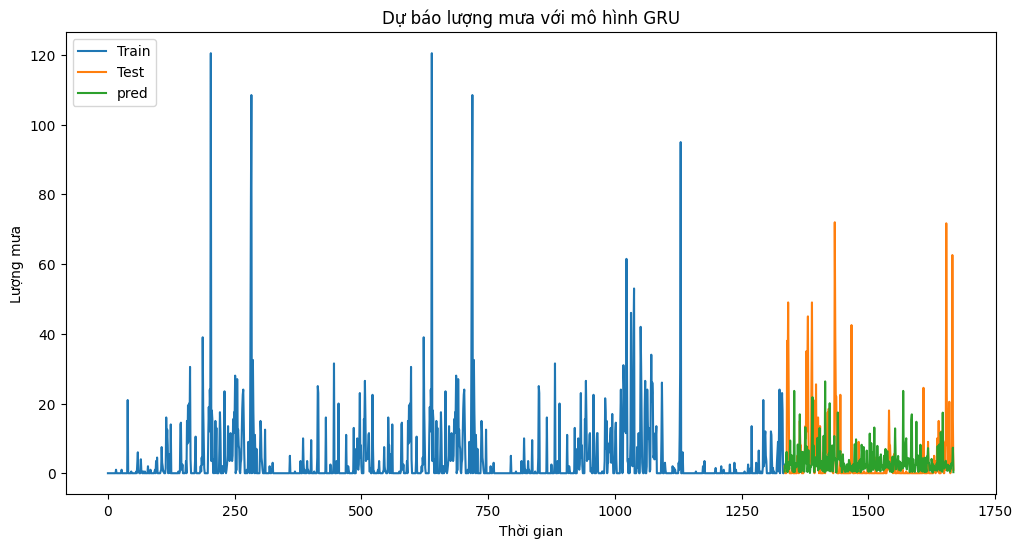

In [24]:
# Vẽ biểu đồ kết quả dự đoán
valid['pred_GRU'] = predict_GRU

plt.figure(figsize=(12, 6))
plt.plot(train['precip'])
plt.plot(valid[['precip', 'pred_GRU']])
plt.title('Dự báo lượng mưa với mô hình GRU')
plt.xlabel('Thời gian')
plt.ylabel('Lượng mưa')
plt.legend(['Train', 'Test', 'pred'], loc='upper left')
plt.show()

### So sánh kết quả của 5 mô hình

In [25]:
print("Root Mean Squared Error (RMSE) of SVM:", rmse_svm)
print("Root Mean Squared Error (RMSE) of XGBoost:", rmse_XGBoost)
print("Root Mean Squared Error (RMSE) of RNN:", rmse_rnn)
print("Root Mean Squared Error (RMSE) of LSTM:", rmse_LSTM)
print("Root Mean Squared Error (RMSE) of GRU:", rmse_GRU)


Root Mean Squared Error (RMSE) of SVM: 9.726854800848265
Root Mean Squared Error (RMSE) of XGBoost: 6.404389453730086
Root Mean Squared Error (RMSE) of RNN: 12.042817572295649
Root Mean Squared Error (RMSE) of LSTM: 11.900712627701106
Root Mean Squared Error (RMSE) of GRU: 10.417125179613706
